# Определение возраста покупателей

## Загрузка данных и получение признаков

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255) 

datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Получилась 7591 фотография. Для решения задачи регрессии данных мало, модели, а особенно нейронной сети, будет сложно обучиться на таком наборе данных. При обучении модели будет необходимо использовать методы размножения данных.

In [4]:
features, target = next(datagen_flow)

print(features.shape)

(32, 224, 224, 3)


Получились признаки — четырёхмерный тензор, в котором 32 изображения размером 224x224 с тремя цветовыми каналами

## Анализ признаков

Посмотрим количество уникальных возрастов

In [5]:
labels.nunique()

file_name    7591
real_age       97
dtype: int64

Посмотрим распределение по возрастам

In [10]:
labels['real_age'].value_counts().head(15)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
22    179
20    178
32    174
40    167
29    164
Name: real_age, dtype: int64

In [7]:
#медианный возраст
labels.median()

real_age    29.0
dtype: float64

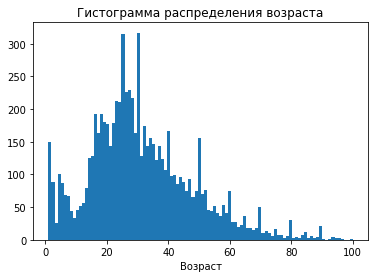

In [9]:
plt.hist(labels['real_age'], bins=100)  
plt.title("Гистограмма распределения возраста")
plt.xlabel("Возраст")
plt.show()


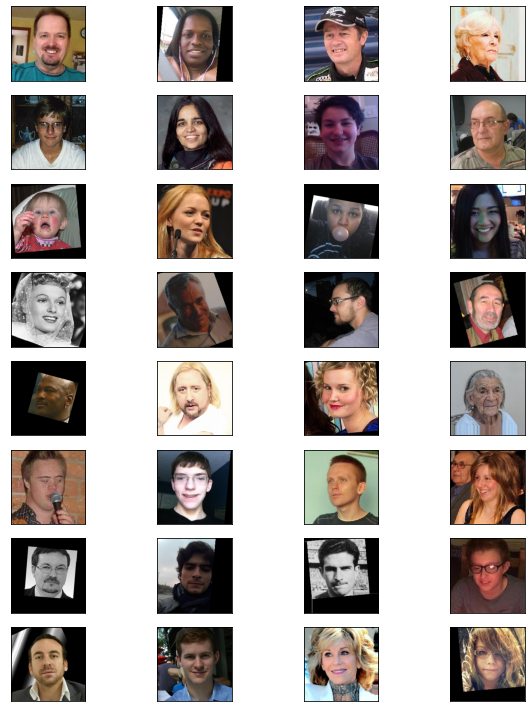

In [11]:
fig = plt.figure(figsize=(10,10))
for i in range(32):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(features[i])
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    

В датасете преобладают люди 30-40 лет. Их большинство, но остальные категории тоже присутсвуют. Модель, вероятно, будет хорошо определять средний возраст, но будет плохо справляться с другими категориями, что плохо, потому что важная задача - определение несовершеннолетних. Также в датасете есть размытые фотографии, которые тоже могут сбивать модель.

## Обучение модели

Дальнейший код был обучен в GPU тренажёре в учебной среде

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, vertical_flip=True) 

    train_data = train_datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        dataframe=labels,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_data
 

    
def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,vertical_flip=False)
    
    test_data = test_datagen.flow_from_dataframe(
        directory=path + 'final_files/',
         x_col='file_name',
         y_col='real_age',
         dataframe=labels,
         target_size=(224, 224),
         batch_size=32,
         class_mode='raw',
         subset='validation',
         seed=12345)

    return test_data


def create_model(input_shape): 
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(66, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
   
    return model




def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Train for 178 steps, validate for 60 steps

Epoch 1/20

178/178 - 65s - loss: 298.5884 - mae: 12.6278 - val_loss: 726.8789 - val_mae: 22.0265

Epoch 2/20

178/178 - 39s - loss: 95.8998 - mae: 7.4055 - val_loss: 642.5931 - val_mae: 20.3237

Epoch 3/20

178/178 - 40s - loss: 62.1363 - mae: 6.0007 - val_loss: 491.9362 - val_mae: 17.2574

Epoch 4/20

178/178 - 39s - loss: 47.2693 - mae: 5.2108 - val_loss: 117.2747 - val_mae: 8.3940

Epoch 5/20

178/178 - 40s - loss: 35.7109 - mae: 4.5246 - val_loss: 82.6717 - val_mae: 6.9221

Epoch 6/20

178/178 - 40s - loss: 27.6474 - mae: 3.9903 - val_loss: 74.1160 - val_mae: 6.5488

Epoch 7/20

178/178 - 39s - loss: 22.5589 - mae: 3.6316 - val_loss: 96.4351 - val_mae: 7.2909

Epoch 8/20

178/178 - 40s - loss: 18.1544 - mae: 3.2448 - val_loss: 71.4636 - val_mae: 6.3347

Epoch 9/20

178/178 - 40s - loss: 14.6089 - mae: 2.9255 - val_loss: 77.5259 - val_mae: 6.5007

Epoch 10/20

178/178 - 40s - loss: 12.8462 - mae: 2.7358 - val_loss: 70.0128 - val_mae: 6.3650

Epoch 11/20

178/178 - 47s - loss: 12.2417 - mae: 2.6278 - val_loss: 75.2830 - val_mae: 6.5700

Epoch 12/20

178/178 - 59s - loss: 11.4283 - mae: 2.5553 - val_loss: 69.6805 - val_mae: 6.3041

Epoch 13/20

178/178 - 55s - loss: 10.4321 - mae: 2.4522 - val_loss: 67.5380 - val_mae: 6.1797

Epoch 14/20

178/178 - 46s - loss: 9.1697 - mae: 2.2852 - val_loss: 73.2240 - val_mae: 6.4691

Epoch 15/20

178/178 - 53s - loss: 8.9278 - mae: 2.2449 - val_loss: 73.7247 - val_mae: 6.3387

Epoch 16/20

178/178 - 58s - loss: 8.9333 - mae: 2.2693 - val_loss: 73.3526 - val_mae: 6.6284

Epoch 17/20

178/178 - 59s - loss: 8.6365 - mae: 2.2197 - val_loss: 71.4813 - val_mae: 6.2793

Epoch 18/20

178/178 - 43s - loss: 8.3382 - mae: 2.1851 - val_loss: 68.0715 - val_mae: 6.1289

Epoch 19/20

178/178 - 58s - loss: 8.0953 - mae: 2.1357 - val_loss: 71.5663 - val_mae: 6.3537

Epoch 20/20

178/178 - 58s - loss: 8.8621 - mae: 2.2210 - val_loss: 68.1173 - val_mae: 6.3766


60/60 - 11s - loss: 68.1173 - mae: 6.3766

Test MAE: 6.3766

```

## Анализ обученной модели

В данном проекте были обработаны фотографии людей для создания системы определения возраста покупателей по фотографиям в прикассовой зоне магазина. 

Для построения модели использовалась нейронная сеть  с частично взятой архитектурой ResNet(верхушка ResNet и несколько дописанных слоев), а также загружались предобученные веса для модели. Данные для обучения были добавлены к основному датасету с помощью аугментации. Также в процессе обучения использовался оптимизатор Adam с параметров learning_rate = 0.0001. Количество эпох = 20 и размер батча = 32.

На последней эпохе видно, что на валидационных данных значение метрики мае составляет 6.37, как и на тестовых. Это говорит о том, что модель не переобучилась и имеет адекватную обобщающую способность.

Полученный результат составляет метрику МАЕ 6.37 на тестовых данных. Относительно задания это хороший результат, но в реальности погрешность в определении возраста в 6 лет это довольно много, потому что основная цель определить несовершеннолетних детей до 18 лет, а 6 лет это треть возраста.  